# Report on using simple neural networks to obtain the degradation rate from a PI signal

All the neural networks considered in this report are fully connected with a few different architectures (different number of layers and different number of neurons per layer) were examined. Since the PI signal is already highly pre-processed, little extra preprocessing steps have been considered. 

The following steps are taken in this analysis:
* The PI signal is obtained using clear sky irradience
* The PI signal is preprocessed to remove the. missing values. In addition, we tried taking the median of the running window to smooth out the signal
* The neural network is trained and tested on each stage of the dataset separetly

### Goal

The goal is to estimate degradation rate. Soiling rate and other losses are ignored in this analysis.

### Summary

The best result was obtained by using 6 layers each with 500 neurons and taking a median over a rolling window of width 15

* RMSE for PI signal in the basic dataset is at 0.016%/year
* RMSE for PI signal in soil dataset is at 0.219%/year
* RMSE for PI signal in weather dataset is at 0.264%/year
* RMSE for PI signal in soil_weather dataset is at 0.245%/year
* RMSE for PI signal in soil_weather_uniform dataset is at 0.407%/year

### Conclusion

This method is very accurate on the basic dataset with the decreasing quite substantially for the more complicated datasets. This potentially can be further improved by using more complicated architetures for the more complex data stages. Moreover, weather dataset performs worse than a more complex soil_weather dataset, which attests to the fact that soil_weather dataset had 150 signals, while soil and weather datasets only had 50 signals each. Hence the performance would most likely improve the soil and weather datasets with the introduction of more data.

However, the biggest take away should be that neural networks can be very useful in combination with other techniques which would separate soiling rates and would smooth the signal. Hence it could be useful in a pipeline currently employed by CODS to estimate the degradation rate from the signal in which soiling and seasonality has been corrected. Unfortunately, due to time constrains this couldn't have been further investigated

### Potential problems

* PI computation use the irradiance sensor (which is subject to sensor drift). However, the contribution of the POA in the computation of PI is small
* All data stages (except for the soil_weather_uniform) have intrinsic bias which is unlikely to mimic the real world, that is, they have normally distributed degradation rates with a fixed mean value. While this is not an issue with analitic techniques, a neural network method could try to leverage this bias to improve performance. Hence testing on a datasets with different distributions of the degradation rates is recommended.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

import os
import datetime
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import tensorflow as tf

from src.models.prepare_model import load_PI_data, split_data_training, create_fully_connected_model
from src.models.train_model import train_model
from src.models.predict_model import load_and_predict_model

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
# Load the results from the most sucessful training
predictions, ys, rmses, X_tests, y_tests = pickle.load(open("fc_6_layers_fancy_outcomes.p", 'rb'))

## Visualisation of the testing data from the most sucessful training

First, we visualise the predicted and actual degradation factors.

Displaying basic dataset


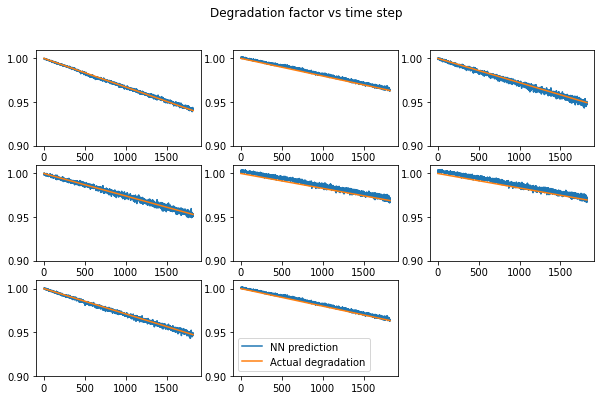

Displaying soil dataset


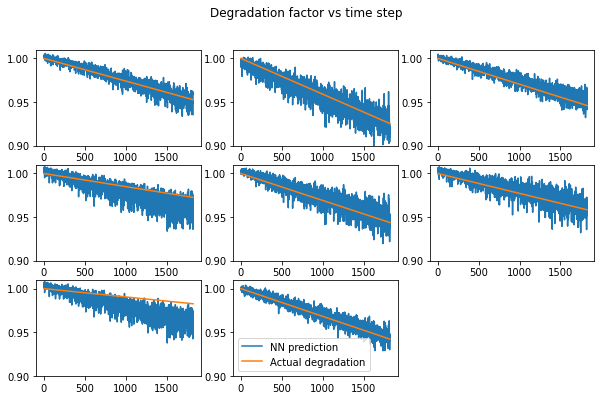

Displaying weather dataset


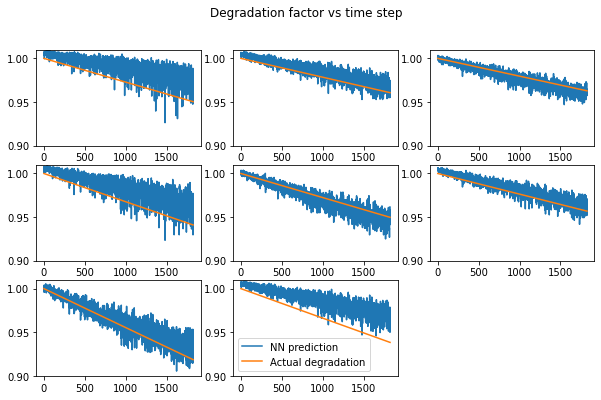

Displaying soil_weather dataset


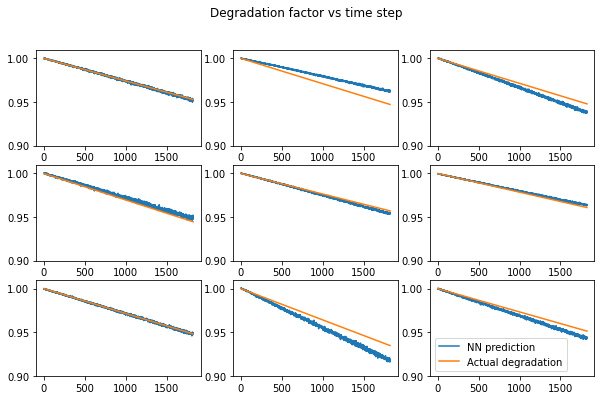

Displaying soil_weather_uniform dataset


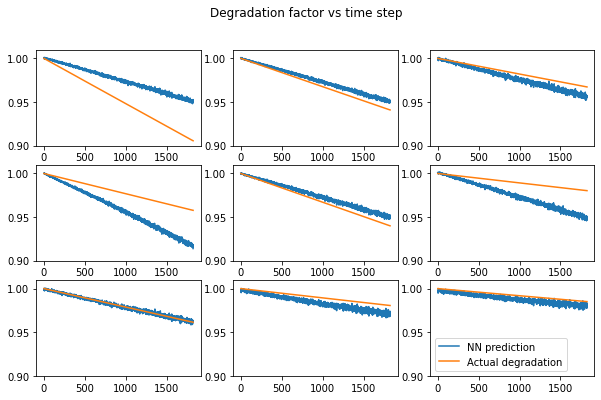

In [3]:
for key in predictions.keys(): 
    print(f"Displaying {key} dataset")
    
    prediction = predictions[key]
    y_test = y_tests[key]
    
    plt.figure(figsize=(10,6))
    plt.tight_layout()
    plt.suptitle("Degradation factor vs time step")
    for i in range(0, min(len(prediction), 9)):
        plt.subplot(3,3,i+1)
        plt.ylim(0.90,1.01)
        plt.plot([x for x in prediction[i]])
        plt.plot([x for x in y_test[i]])
    plt.legend(['NN prediction','Actual degradation'])
    plt.show()

Secondly, we visualise predicted vs yearly degradation rates. For this visualisation it is assumed that the rate is constant.

Displaying basic dataset
RMSE is 0.016%/year


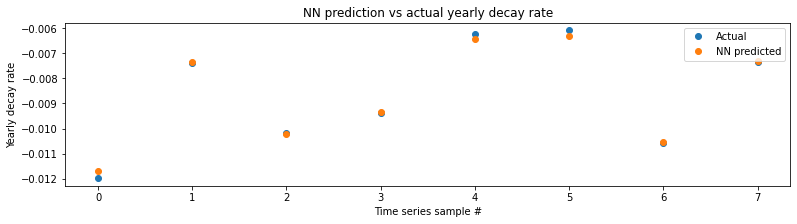

Displaying soil dataset
RMSE is 0.219%/year


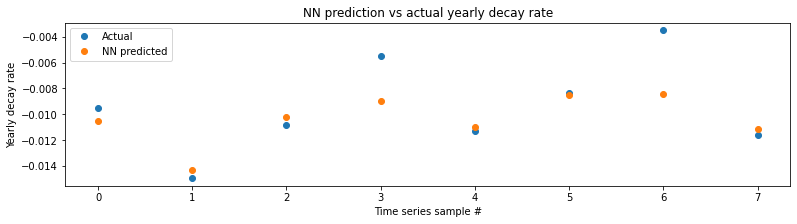

Displaying weather dataset
RMSE is 0.264%/year


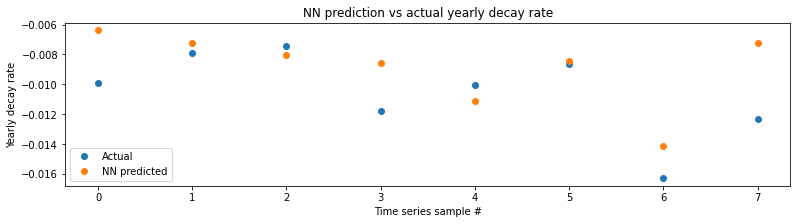

Displaying soil_weather dataset
RMSE is 0.245%/year


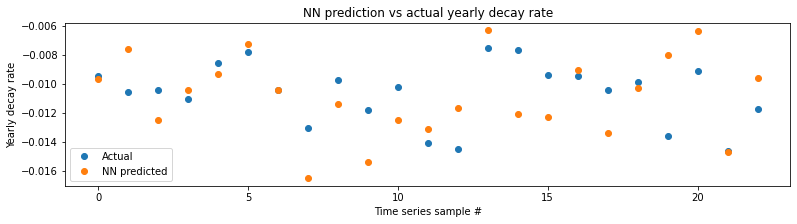

Displaying soil_weather_uniform dataset
RMSE is 0.407%/year


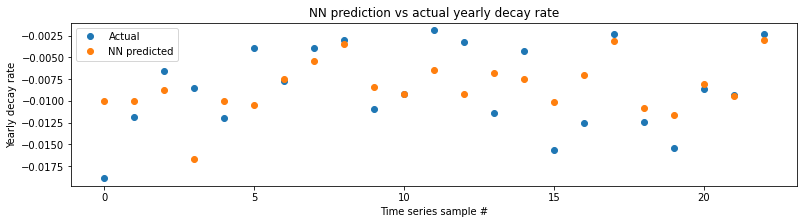

In [4]:
def extract_yr_degrad(avg_power_decay):
    x = np.array([i/365 for i in range(0,len(avg_power_decay))])
    y = np.array(avg_power_decay)
    return np.polyfit(x,y,1)[0]

model_pred = {} 
degradation_rates_test = {} 

for key in predictions.keys():
    model_pred[key] = []
    degradation_rates_test[key] = []
    for i in range(0, len(predictions[key])):
        model_pred[key].append(extract_yr_degrad(predictions[key][i, :]))
        degradation_rates_test[key].append(extract_yr_degrad(y_tests[key][i]))

for key in predictions.keys():  
    print(f"Displaying {key} dataset")
    prediction = predictions[key]
    y_test = y_tests[key]
    mse = mean_squared_error(model_pred[key], degradation_rates_test[key])
    print(f"RMSE is {np.sqrt(mse)*100:0.3f}%/year")
    
    plt.figure(figsize=(13,3))
    plt.plot(degradation_rates_test[key], 'o')
    plt.plot(model_pred[key], 'o')
    plt.xlabel("Time series sample #")
    plt.ylabel("Yearly decay rate")
    plt.title("NN prediction vs actual yearly decay rate")
    plt.legend(["Actual","NN predicted"])
    plt.show()